In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
from scipy.integrate import quad ## FUNCTIONS TO IMPLEMENT GAUSS-QUADRATURE
# from scipy.integrate import quad_vec ## FUNCTIONS TO IMPLEMENT GAUSS-QUADRATURE
from scipy.special import hermite,legendre
from scipy.linalg import eigh
import time
np.random.seed(20)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
t1=time.time()

In [3]:
# This will set the default to float32 or float64 but not float16
torch.set_default_dtype(torch.float32)

In [4]:
# current_device = torch.cuda.current_device()
# torch.cuda.get_device_properties(current_device)

In [5]:
# Set the default tensor type to use GPU if available
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch.set_default_tensor_type(torch.FloatTensor)
torch.set_default_tensor_type(torch.FloatTensor)

C:\Users\CMMRG\anaconda3\Lib\site-packages\torch\__init__.py:749: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ..\torch\csrc\tensor\python_tensor.cpp:433.)
  _C._set_default_tensor_type(t)


In [6]:
# Define the orthonormal probabilistic Hermite polynomial
def orthonormal_prob_hermite(n):
    return lambda x: hermite(n)(x/np.sqrt(2.0)) / np.sqrt((2.0)**n * np.math.factorial(n))

# Define the orthonormal probabilistic Legendre polynomial
def orthonormal_legendre(n):
    return lambda x: legendre(n)(x) * np.sqrt(n+0.5)

# Define the integrand for scalar product
def scalar_int(i,j):
    return lambda x:orthonormal_prob_hermite(i)(x) * orthonormal_prob_hermite(j)(x) * np.exp(-(x**2/2))/np.sqrt(2*np.pi)

# Define the integrand for triple product
def triple_int(i,j,k):
    return lambda x:orthonormal_prob_hermite(i)(x) * orthonormal_prob_hermite(j)(x)* orthonormal_prob_hermite(k)(x) * np.exp(-(x**2/2))/np.sqrt(2*np.pi)

# Integrate to verify orthonormality
integral1, _ = quad(scalar_int(2,2), -np.inf, np.inf)
integral2, _ = quad(scalar_int(2,3), -np.inf, np.inf)
print(f"The scalar product of the orthonormal probabilistic Hermite polynomials H_2(x) and H_2(x) is approximately {integral1}")
print(f"The scalar product of the orthonormal probabilistic Hermite polynomials H_2(x) and H_3(x) is approximately {integral2}")

The scalar product of the orthonormal probabilistic Hermite polynomials H_2(x) and H_2(x) is approximately 1.0000000000000022
The scalar product of the orthonormal probabilistic Hermite polynomials H_2(x) and H_3(x) is approximately 0.0


C:\Users\CMMRG\AppData\Local\Temp\ipykernel_1800\293942335.py:3: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return lambda x: hermite(n)(x/np.sqrt(2.0)) / np.sqrt((2.0)**n * np.math.factorial(n))


In [7]:
k=1
con = 1
particles_per_unit=50*k
dx = con/particles_per_unit
ratio=1.6
h=ratio*dx
c_ = 2 * h
q=30
max_ord=3
n_samples=96 * 50

J = particles_per_unit**2 #total number of particles
rho = 1000*torch.ones(J)  ## for steel
mass = rho * dx**2
rho0=rho
vis=0.05
T = 0.3               # Total time of integration
dt = 0.003          # Time step
N = int(T/dt)
N  

100

In [8]:
def find_combinations(q, max_ord,current_sum=0, current_combination=None, all_combinations=None):
    if current_combination is None:
        current_combination = []
    if all_combinations is None:
        all_combinations = []
        
    if len(current_combination) == q:
        if current_sum < max_ord:
            all_combinations.append(current_combination[:])
        return all_combinations
    
    for i in range(max_ord - current_sum):
        current_combination.append(i)
        find_combinations(q, max_ord,current_sum + i, current_combination, all_combinations)
        current_combination.pop()

    return all_combinations

In [9]:
index=np.array(find_combinations(q,max_ord))
P=index.shape[0]
P

496

In [10]:
index

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 2],
       ...,
       [1, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0]])

In [11]:
x_values = torch.linspace(0, 1*con, particles_per_unit)
y_values = torch.linspace(0, 1*con, particles_per_unit)
# Create a meshgrid
X, Y = torch.meshgrid(x_values, y_values)
# print(X.shape)

# Flatten the meshgrid arrays for 1D function application
X_flat = X.flatten()
Y_flat = Y.flatten()

temp=tuple(zip(X_flat,Y_flat))
temp=torch.tensor(temp)
coords=torch.zeros(P,J,2)
coords[0]=temp

C:\Users\CMMRG\anaconda3\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [12]:
def create_sample(i):
    np.random.seed(i)
    L=4
    a_ij = np.random.normal(0, 1, (2,2*L+1, 2*L+1))
    b_ij = np.random.normal(0, 1, (2,2*L+1, 2*L+1))
    c = np.random.uniform(-1, 1, 2)
    
    
    # Define the w(x, y) function
    def w(x, y,n=particles_per_unit):
        result = torch.zeros(2,n,n).cpu()
        m = torch.ones(2,n,n).cpu()
        for i in range(-L, L+1):
            for j in range(-L, L+1):
                result[0] += (a_ij[0,i+L, j+L] * np.sin(2*np.pi*(i*x.cpu() + j*y.cpu())) + b_ij[0,i+L, j+L] * np.cos(2*np.pi*(i*x.cpu() + j*y.cpu())))
                result[1] += (a_ij[1,i+L, j+L] * np.sin(2*np.pi*(i*x.cpu() + j*y.cpu())) + b_ij[1,i+L, j+L] * np.cos(2*np.pi*(i*x.cpu() + j*y.cpu()))) 
        m[0] = 10*(1-(np.exp((y.cpu())*(1-y.cpu())))) *(1-(np.exp((-x.cpu())*(1-x.cpu()))))
        m[1] = 10*(1-(np.exp((y.cpu())*(1-y.cpu())))) *(1-(np.exp((-x.cpu())*(1-x.cpu()))))
        return result,m


    # Calculate w(x, y) over the grid
    W,m = w(X, Y)
    # print(W.shape)
    # # Calculate u(x, y, t=0)
    # temp = W
    temp = 2 * W / torch.max(torch.abs(W)).cpu()
    temp[0] = (temp[0] + c[0])*m[0]
    temp[1] = (temp[1] + c[1])*m[1]
    u0 = torch.zeros((2, J))
    u0[0,:]=temp[0,:,:].flatten()
    u0[1,:]=temp[1,:,:].flatten()
    return u0

In [13]:
# u_init=torch.zeros((2,particles_per_unit**2,n_samples))
# for i in range(n_samples):
#     print(f"Starting the {i}th iteration")
#     u_init[:,:,i]=create_sample(i)

In [14]:
with open('u_init.pkl', 'rb') as file:
    u_init = torch.tensor(pickle.load(file), dtype=torch.float32).permute(1, 0, 2)

In [15]:
u_init.shape

torch.Size([2, 2500, 5001])

In [16]:
# u_stacked = u_init.transpose(1, 2).reshape(2, 2000, 2500)
u_stacked = u_init

# Compute the covariance matrix for each component (x and y)
cov_matrices = []
for component in range(2):
    u_component = u_stacked[component]  # Select either x or y component
    # Subtract the mean along the sample dimension (axis=1)
    u_mean = torch.mean(u_component, dim=(1), keepdim=True)
    u_centered = u_component - u_mean
    # Compute covariance matrix
    covariance_matrix = torch.matmul(u_centered, u_centered.transpose(1, 0)) / (u_component.shape[1] - 1)
    cov_matrices.append(covariance_matrix)

# cov_matrices now contains the covariance matrix for each component
cov_x = cov_matrices[0]  # Covariance matrix for x component
cov_y = cov_matrices[1]  # Covariance matrix for y component

# If you want the combined covariance matrix, you can stack them together
cov_combined = torch.stack(cov_matrices, dim=0)

print("Covariance matrix for x component:\n", cov_x.shape)
print("Covariance matrix for y component:\n", cov_y.shape)
print("Combined covariance matrix:\n", cov_combined.shape)

Covariance matrix for x component:
 torch.Size([2500, 2500])
Covariance matrix for y component:
 torch.Size([2500, 2500])
Combined covariance matrix:
 torch.Size([2, 2500, 2500])


In [17]:
# Compute the eigenvalues_x and eigenvectors_x of the covariance matrix
eigenvalues_x, eigenvectors_x = eigh(cov_x.cpu())

# Sort the eigenvalues_x and eigenvectors_x in descending order
idx = eigenvalues_x.argsort()[::-1]
eigenvalues_x = torch.tensor(eigenvalues_x[idx])
eigenvectors_x = torch.tensor(eigenvectors_x[:, idx])
eigenvalues_x

tensor([ 9.8856e+01,  4.0016e+00,  3.8163e+00,  ..., -1.0178e-06,
        -1.1576e-06, -1.1421e-05])

In [18]:
# Compute the eigenvalues_y and eigenvectors_y of the covariance matrix
eigenvalues_y, eigenvectors_y = eigh(cov_y.cpu())

# Sort the eigenvalues_y and eigenvectors_y in descending order
idx = eigenvalues_y.argsort()[::-1]
eigenvalues_y = torch.tensor(eigenvalues_y[idx])
eigenvectors_y = torch.tensor(eigenvectors_y[:, idx])
eigenvalues_y

tensor([ 9.2256e+01,  3.9918e+00,  3.8531e+00,  ..., -7.1226e-07,
        -4.5170e-06, -1.3182e-05])

In [19]:
eigenvalues_x[356:          366]

tensor([1.1248e-08, 1.1246e-08, 1.1236e-08, 1.1209e-08, 1.1181e-08, 1.1160e-08,
        1.1128e-08, 1.1116e-08, 1.1115e-08, 1.1105e-08])

In [20]:
u0_mean=u_init.mean(dim=(2))
u0_std=u_init.std(dim=(2))

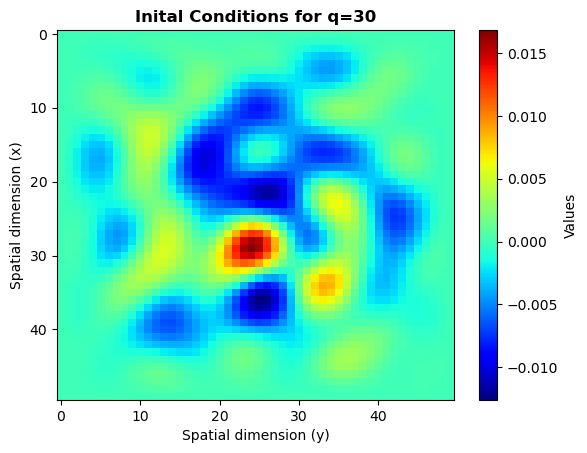

In [21]:
u_plot=u0_mean[1,:].cpu().reshape((int(np.sqrt(J)), int(np.sqrt(J))))
heatmap=plt.imshow(u_plot, aspect='auto', cmap='jet')
plt.xlabel('Spatial dimension (y)')
plt.ylabel('Spatial dimension (x)')
plt.title(f'Inital Conditions for q={q}', fontweight='bold')
cbar = plt.colorbar(heatmap)
# Add colorbar with legend
# cbar = plt.colorbar(heatmap)
cbar.set_label('Values')
plt.show()

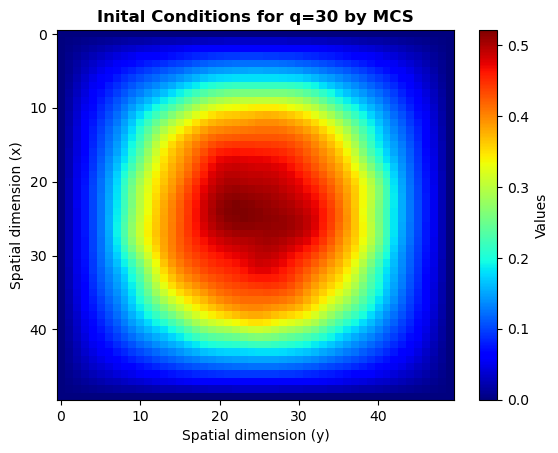

In [22]:
u_plot=u0_std[1,:].cpu().reshape((int(np.sqrt(J)), int(np.sqrt(J))))
heatmap=plt.imshow(u_plot, aspect='auto', cmap='jet')
plt.xlabel('Spatial dimension (y)')
plt.ylabel('Spatial dimension (x)')
plt.title(f'Inital Conditions for q={q} by MCS', fontweight='bold')
cbar = plt.colorbar(heatmap)
# Add colorbar with legend
# cbar = plt.colorbar(heatmap)
cbar.set_label('Values')
plt.show()

In [23]:
t=0
# q=100
for i in range(q):
    t+=eigenvalues_y[i]*(eigenvectors_y[:,i]**2)
t=torch.sqrt(t)

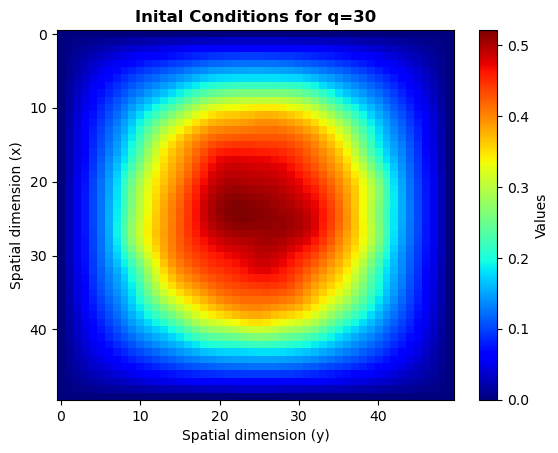

In [24]:
u_plot=t.cpu().reshape((int(np.sqrt(J)), int(np.sqrt(J))))
heatmap=plt.imshow(u_plot, aspect='auto', cmap='jet')
plt.xlabel('Spatial dimension (y)')
plt.ylabel('Spatial dimension (x)')
plt.title(f'Inital Conditions for q={q}', fontweight='bold')
cbar = plt.colorbar(heatmap)
# Add colorbar with legend
# cbar = plt.colorbar(heatmap)
cbar.set_label('Values')
plt.show()

In [25]:
def cal_u(wx,wy):
    val=u0_mean
    
    for i in range(q):
        val[0]+=torch.sqrt(eigenvalues_x[i])*(eigenvectors_x[:,i])*wx[i]
        val[1]+=torch.sqrt(eigenvalues_y[i])*(eigenvectors_y[:,i])*wy[i]
    
    return val

In [26]:
values=torch.zeros(size=(2,P,J))
values[:,0,:]=u0_mean
for i in range(1,P):
    print(i)
    val=torch.zeros_like(u0_mean)
    for j in range(q):
        k = index[i][j]
        if (k==1 and np.sum(index[i])==1) or k==2:
            temp,_=quad(lambda x: orthonormal_prob_hermite(k)(x) * x * np.exp(-(x**2/2))/np.sqrt(2*np.pi), -np.inf, np.inf)
            if(abs(temp)<1e-5):
                temp=0
            # print(f"{k} for nananaaaa naaa{temp}")
            val[0]+=torch.sqrt(eigenvalues_x[j])*eigenvectors_x[:,j]*temp
            val[1]+=torch.sqrt(eigenvalues_y[j])*eigenvectors_y[:,j]*temp
            break
    values[:,i,:]=val


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


C:\Users\CMMRG\AppData\Local\Temp\ipykernel_1800\293942335.py:3: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return lambda x: hermite(n)(x/np.sqrt(2.0)) / np.sqrt((2.0)**n * np.math.factorial(n))


22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
29

In [27]:
ut = torch.zeros((2, P, J, N+1))
ut[:,:,:,0]=torch.tensor(values)
values

C:\Users\CMMRG\AppData\Local\Temp\ipykernel_1800\410624087.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ut[:,:,:,0]=torch.tensor(values)


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [28]:
torch.max(torch.abs(u_init))

tensor(2.2617)

In [29]:
del u_init

In [30]:
pre_b=torch.zeros((max_ord,max_ord),device='cpu')
for i in range(max_ord):
    for j in range(max_ord):
        pre_b[i,j],_=quad(lambda x: orthonormal_prob_hermite(i)(x)*orthonormal_prob_hermite(j)(x)* np.exp(-(x**2/2))/np.sqrt(2*np.pi), -np.inf, np.inf)
        if(abs(pre_b[i,j])<1e-10):
            pre_b[i,j]=0
pre_b

C:\Users\CMMRG\AppData\Local\Temp\ipykernel_1800\293942335.py:3: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return lambda x: hermite(n)(x/np.sqrt(2.0)) / np.sqrt((2.0)**n * np.math.factorial(n))


tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

In [31]:
pre_c=torch.zeros((max_ord,max_ord,max_ord),device='cpu')
for i in range(max_ord):
    for j in range(max_ord):
        for k in range(max_ord):
            pre_c[i,j,k],_=quad(lambda x: orthonormal_prob_hermite(i)(x)*orthonormal_prob_hermite(j)(x)* orthonormal_prob_hermite(k)(x) *np.exp(-(x**2/2))/np.sqrt(2*np.pi), -np.inf, np.inf)
            if(abs(pre_c[i,j,k])<1e-10):
                pre_c[i,j,k]=0
pre_c

C:\Users\CMMRG\AppData\Local\Temp\ipykernel_1800\293942335.py:3: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return lambda x: hermite(n)(x/np.sqrt(2.0)) / np.sqrt((2.0)**n * np.math.factorial(n))


tensor([[[1.0000, 0.0000, 0.0000],
         [0.0000, 1.0000, 0.0000],
         [0.0000, 0.0000, 1.0000]],

        [[0.0000, 1.0000, 0.0000],
         [1.0000, 0.0000, 1.4142],
         [0.0000, 1.4142, 0.0000]],

        [[0.0000, 0.0000, 1.0000],
         [0.0000, 1.4142, 0.0000],
         [1.0000, 0.0000, 2.8284]]])

In [32]:
a=torch.zeros((P),device='cpu')
for i in range(P):
    if(np.sum(index[i]) == 0):
        a[i]=1

In [33]:
def cal_b(i, pre_b, index):
    print(f"Starting {i}th iteration")
    b = torch.zeros(size=(P,),device='cpu')
    for j in range(P):
        b[j]=1
        for k in range(q):
            b[j]*=pre_b[index[i][k],index[j][k]]
    return b

In [34]:
index=torch.tensor(index,device='cpu')

In [35]:
def cal_c(i, pre_c, index):
    print(f"Starting {i}th iteration")
    P, q = index.shape
#     index=torch.tensor(index)
    # Initialize the output tensor c with ones
    c = torch.ones((P, P), dtype=pre_c.dtype, device=pre_c.device)
    
    # Iterate over the range Q and perform element-wise multiplication for all combinations
    for l in range(q):
        idx_i = index[i, l]
        idx_j = index[:, l].unsqueeze(1).expand(P, P)
        idx_k = index[:, l].unsqueeze(0).expand(P, P)
        c *= pre_c[idx_i, idx_j, idx_k]
    
    return c

In [36]:
import time
import multiprocessing
from joblib import Parallel, delayed
import sys


In [37]:
num_cores=multiprocessing.cpu_count()
num_cores

16

In [38]:

start = time.time()

b = Parallel(n_jobs=num_cores)(delayed(cal_b)(i, pre_b, index) for i in range(P))
c = Parallel(n_jobs=num_cores)(delayed(cal_c)(i, pre_c, index) for i in range(P))

end = time.time()

In [39]:
print(f"Total time taken {(end-start)/60} mins")

Total time taken 0.529431406656901 mins


In [40]:
b=torch.stack(b,dim=0)
b.shape

torch.Size([496, 496])

In [41]:
c=torch.stack(c,dim=0)
c.shape

torch.Size([496, 496, 496])

In [42]:
ab = a.view(P, 1, 1) * b

In [43]:
def compute_nlist(coords,side_length=float(con)):
    # Compute pairwise distance
    # Shifts
    eps = 0.1*h
    shifts = [
        (0, 0)        # Original coordinates
        # (side_length, 0),  # Shift right
        # (-side_length, 0), # Shift left
        # (0, side_length),  # Shift up
        # (0, -side_length), # Shift down 
        # (side_length + eps, -side_length - eps),  # Shift right - down
        # (-side_length - eps, side_length + eps), # Shift left - up
        # (side_length + eps, side_length + eps),  # Shift right - up
        # (-side_length - eps, -side_length - eps)  # Shift left - down 
    ]
    n_particles=coords.size()[0]
    # Expand the coordinates
    
    all_coords = []
    for shift in shifts:
        shifted_coords = coords + torch.tensor(shift,dtype=coords.dtype)
        all_coords.append(shifted_coords)

    
    all_coords = torch.cat(all_coords, dim=0)
    
    # Compute pairwise distances
    dX = all_coords[:, 0][:, None] - coords[:, 0][None, :]
    dY = all_coords[:, 1][:, None] - coords[:, 1][None, :]
    # print(dX.shape)
    # half_domain = side_length / 2
    # dX = (dX + half_domain) % side_length - half_domain
    # dY = (dY + half_domain) % side_length - half_domain
    
    distances = torch.sqrt(dX**2 + dY**2)

    # Create the neighbor list using a mask for distances < c and excluding self-distances
    neighbor_mask = (distances <= c_) & (distances > 0)
    # print(neighbor_mask.shape)
    # Compute the neighbor list
    n_list = [[torch.nonzero(neighbor_mask[i]).squeeze() % n_particles,(dX[i][neighbor_mask[i]]),(dY[i][neighbor_mask[i]])] for i in range(J)]
    
    return n_list

n_list=compute_nlist(coords[0])
len(n_list[0][1])

10

In [44]:
n_list[0][0]

tensor([  1,   2,   3,  50,  51,  52, 100, 101, 102, 150])

In [45]:
def d_CubicSpline(x, y, h, domain_size=1):
    alpha = 15/(7*np.pi*h**2)


    r = torch.sqrt(x**2 + y**2)
    q = r / h
    mask1 = q <= 1
    mask2 = (q > 1) & (q <= 2)
    dz_dx = torch.zeros_like(q)
    dz_dy = torch.zeros_like(q)

    dz_dx[mask1] = alpha * (-2*q[mask1] + 3/2*q[mask1]**2) * x[mask1] / (r[mask1] * h)
    dz_dy[mask1] = alpha * (-2*q[mask1] + 3/2*q[mask1]**2) * y[mask1] / (r[mask1] * h)
    dz_dx[mask2] = alpha * (-1/2*(2-q[mask2])**2) * x[mask2] / (r[mask2] * h)
    dz_dy[mask2] = alpha * (-1/2*(2-q[mask2])**2) * y[mask2] / (r[mask2] * h)
    
    return dz_dx, dz_dy


In [46]:
def compute_A(x, y, h, m_j, rho_j, epsilon=1e-8):
    alpha = 15 / (7 * np.pi * h ** 2)
    r = torch.sqrt(x**2 + y**2)
    q = r / h
    mask1 = q <= 1
    mask2 = (q > 1) & (q <= 2)
    
    W_xx = torch.zeros_like(q)
    W_yy = torch.zeros_like(q)
    
    W_xx[mask1] = alpha * (-2 * q[mask1] + 3/2 * q[mask1]**2) * (x[mask1]) / (r[mask1] * h)
    W_yy[mask1] = alpha * (-2 * q[mask1] + 3/2 * q[mask1]**2) * (y[mask1]) / (r[mask1] * h)
    W_xx[mask2] = alpha * (-1/2 * (2 - q[mask2])**2) * (x[mask2]) / (r[mask2] * h)
    W_yy[mask2] = alpha * (-1/2 * (2 - q[mask2])**2) * (y[mask2]) / (r[mask2] * h)
    
    A_xx = -torch.sum(m_j * x / rho_j * W_xx)
    A_xy = -torch.sum(m_j * x / rho_j * W_yy)
    A_yx = -torch.sum(m_j * y / rho_j * W_xx)
    A_yy = -torch.sum(m_j * y / rho_j * W_yy)
    
    A_inv = torch.linalg.inv(torch.tensor([[A_xx, A_xy], [A_yx, A_yy]]))
    return A_inv

def d_CubicSpline_corrected(x, y, h, m_j, rho_j):
    # Compute the gradient of the kernel
    dz_dx, dz_dy = d_CubicSpline(x, y, h)
    
    # Compute the correction matrix A_inv
    B = compute_A(x, y, h, m_j, rho_j)
    
    # Apply the gradient correction
    dz_dx_corrected = B[0, 0] * dz_dx + B[0, 1] * dz_dy
    dz_dy_corrected = B[1, 0] * dz_dx + B[1, 1] * dz_dy
    
    return dz_dx_corrected, dz_dy_corrected

In [47]:
def SPH(c,h,comp,n_list=n_list):
    cd=torch.zeros(size=(2,P,c.shape[1]))
    for i,data in enumerate(n_list):
        neighbors = data[0]
        c_i = c[:,i][:,np.newaxis]  # Broadcasting to create the necessary shape
        c_i = torch.tensor(np.repeat(c_i.cpu(), len(neighbors), axis=1),device=cd.device)
        c_j = c[:,neighbors]
        rho_neighbors = rho[neighbors]
        mass_neighbors = mass[neighbors]
        
        c_diff = c_i - c_j
        # dx,dy=d_CubicSpline_corrected(data[1],data[2], h, mass_neighbors, rho_neighbors)
        dx,dy=d_CubicSpline(data[1],data[2],h)
        cd[0,:,i] = torch.einsum("N,PN->P", mass_neighbors / rho_neighbors * dx, c_diff)
        cd[1,:,i] = torch.einsum("N,PN->P", mass_neighbors / rho_neighbors * dy, c_diff)
    return cd

In [48]:
def SPH_d(c,h,n_list=n_list):
    cd=torch.zeros_like(c)
    for i,data in enumerate(n_list):
        neighbors = data[0]
        c_i = c[:,:,i][:,:,np.newaxis]  # Broadcasting to create the necessary shape
        c_i = torch.tensor(np.repeat(c_i.cpu(), len(neighbors), axis=2),device=cd.device)
        c_j = c[:,:,neighbors]
        rho_neighbors = rho[neighbors]
        mass_neighbors = mass[neighbors]
        c_diff = (c_i - c_j)
        # dx,dy=d_CubicSpline_corrected(data[1],data[2], h, mass_neighbors, rho_neighbors)
        dx,dy=d_CubicSpline(data[1],data[2],h)
        cd[0,:,i] = torch.einsum("N,PN->P",mass_neighbors / rho_neighbors * dx, c_diff[0,:,:])
        cd[1,:,i] = torch.einsum("N,PN->P",mass_neighbors / rho_neighbors * dy, c_diff[1,:,:])
    return cd

In [49]:
def xSPH(c,h,n_list=n_list):
    cd=torch.zeros_like(c)
    for i,data in enumerate(n_list):
        neighbors = data[0]
        c_i = c[:,:,i][:,:,np.newaxis]  # Broadcasting to create the necessary shape
        c_i = torch.tensor(np.repeat(c_i.cpu(), len(neighbors), axis=2),device=cd.device)
        c_j = c[:,:,neighbors]
        rho_neighbors = rho[neighbors]
        mass_neighbors = mass[neighbors]
        c_diff = (c_j - c_i)
        # dx,dy=d_CubicSpline_corrected(data[1],data[2], h,mass_neighbors,rho_neighbors)
        dx,dy=d_CubicSpline(data[1],data[2],h)
        # cd[0,:,i] = torch.sum(mass_neighbors / rho_neighbors * c_diff * dx)
        cd[0,:,i] = 0.5*torch.einsum("N,PN->P",mass_neighbors / rho_neighbors * dx, c_diff[0,:,:])
        cd[1,:,i] = 0.5*torch.einsum("N,PN->P",mass_neighbors / rho_neighbors * dy, c_diff[1,:,:])
        # cd[0,0,i] += torch.sum(mass_neighbors / rho_neighbors * (pi_ij) * dx)
        # cd[1,0,i] += torch.sum(mass_neighbors / rho_neighbors * (pi_ij) * dy)
    return cd

In [50]:
# Define the function to detect and correct outliers based on the median
def median_outlier_correction(ut, neighborlist):
    # Iterate over all particles
    for j in range(ut.shape[2]):
        neighbors = neighborlist[j][0]
        if len(neighbors) > 0:  # Check if the particle has neighbors
            # Compute the median velocity from the neighbors
            median_velocity_x = torch.median(ut[0, :, neighbors], dim=1).values
            median_velocity_y = torch.median(ut[1, :, neighbors], dim=1).values
            # Update the velocity of the current particle to the median velocity of neighbors
            ut[0, :, j] = median_velocity_x
            ut[1, :, j] = median_velocity_y

In [51]:
coordinates=torch.zeros((P,J,2,N+1))
coordinates[:,:,:,0]=coords

In [52]:
# coords[1,:51,0]

In [53]:
x_mask = torch.logical_or(coords[0,:,0] == 0, coords[0,:,0] == 1)
y_mask = torch.logical_or(coords[0,:,1] == 0, coords[0,:,1] == 1)

In [54]:
x_mask[:100]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])

In [55]:
ut.shape

torch.Size([2, 496, 2500, 101])

In [56]:
for n in range(1, N+1):
    # Predictor step
    n_list = compute_nlist(coords[0])
    u = ut[:, :, :, n - 1]
    
    # Derivatives for predictor
    ux_d = SPH(u[0], h, 0)
    uy_d = SPH(u[1], h, 1)
    ux_dd = SPH_d(ux_d, h)
    uy_dd = SPH_d(uy_d, h)
    ux_dy = ux_d[1,0,:]
    uy_dx= uy_d[0,0,:]
    
    # Compute right-hand side for predictor
    rhsx = torch.einsum('ji,ki,klj->li', u[0], ux_d[0], c) + torch.einsum('pi,i->pi',u[1],ux_dy) \
           - vis * (ux_dd[0] + ux_dd[1])
    rhsy = torch.einsum('pi,i->pi',u[0],uy_dx) + torch.einsum('ji,ki,klj->li', u[1], uy_d[1], c) \
           - vis * (uy_dd[0] + uy_dd[1])
    
    # Predict new values of u (predictor estimate)
    # u_pred_x = u[0] - rhsx * dt
    # u_pred_y = u[1] - rhsy * dt
    ut[0, :, :, n] = u[0] - rhsx * dt
    ut[1, :, :, n] = u[1] - rhsy * dt
    
    # Corrector step
    # Update the derivatives and right-hand side using the predictor values
    # ux_d_pred = SPH(u_pred_x, h, 0)
    # uy_d_pred = SPH(u_pred_y, h, 1)
    # ux_dd_pred = SPH_d(ux_d_pred, h)
    # uy_dd_pred = SPH_d(uy_d_pred, h)
    
    # # Compute right-hand side for corrector
    # rhsx_pred = torch.einsum('ji,ki,jlk->li', u_pred_x, ux_d_pred[0], c) + torch.einsum('ji,ki,jlk->li', u_pred_y, ux_d_pred[1], c) \
    #             - vis * (ux_dd_pred[0] + ux_dd_pred[1])
    # rhsy_pred = torch.einsum('ji,ki,jlk->li', u_pred_x, uy_d_pred[0], c) + torch.einsum('ji,ki,jlk->li', u_pred_y, uy_d_pred[1], c) \
    #             - vis * (uy_dd_pred[0] + uy_dd_pred[1])
    
    # Correct the time integration with the average of predictor and corrector rhs
    # ut[0, :, :, n] = u[0] - 0.5 * (rhsx + rhsx_pred) * dt
    # ut[1, :, :, n] = u[1] - 0.5 * (rhsy + rhsy_pred) * dt
    
    # Boundary conditions
    ut[0, :, torch.logical_or(x_mask,y_mask), n] = 0
    ut[1, :, torch.logical_or(x_mask,y_mask), n] = 0

    coords = coords +  (ut[:,:,:,n]).transpose(0,2).transpose(0,1) * dt
    coordinates[:,:,:,n]=coords
    print(f"Completed the {n}^th timestep")

C:\Users\CMMRG\AppData\Local\Temp\ipykernel_1800\4027079884.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c_i = torch.tensor(np.repeat(c_i.cpu(), len(neighbors), axis=1),device=cd.device)


Completed the 1^th timestep
Completed the 2^th timestep
Completed the 3^th timestep
Completed the 4^th timestep
Completed the 5^th timestep
Completed the 6^th timestep
Completed the 7^th timestep
Completed the 8^th timestep
Completed the 9^th timestep
Completed the 10^th timestep
Completed the 11^th timestep
Completed the 12^th timestep
Completed the 13^th timestep
Completed the 14^th timestep
Completed the 15^th timestep
Completed the 16^th timestep
Completed the 17^th timestep
Completed the 18^th timestep
Completed the 19^th timestep
Completed the 20^th timestep
Completed the 21^th timestep
Completed the 22^th timestep
Completed the 23^th timestep
Completed the 24^th timestep
Completed the 25^th timestep
Completed the 26^th timestep
Completed the 27^th timestep
Completed the 28^th timestep
Completed the 29^th timestep
Completed the 30^th timestep
Completed the 31^th timestep
Completed the 32^th timestep
Completed the 33^th timestep
Completed the 34^th timestep
Completed the 35^th tim

In [57]:
import pickle

with open('results_pce_12_new.pkl', 'wb') as file:
    pickle.dump(ut.numpy(), file)
with open('coords_pce_12_new.pkl', 'wb') as file:
    pickle.dump(coordinates.numpy(), file)

In [58]:
t2=time.time()

In [59]:
print(f"Total time taken {(t2-t1)/60} mins")

Total time taken 22.454259856541952 mins
